In [17]:
import pandas as pd
import seaborn as sns
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
from statsbombpy import sb
from pandas import json_normalize
import numpy as np
import requests
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker

# THE CELL BELOW TAKES THE RATING FOR EACH PLAYER FROM WHOSCORED.COM AND GENERATES A GRID OF ALL THE PLAYER RATINGS. THE DROPOFF IS AN EXPONENTIAL DECAY

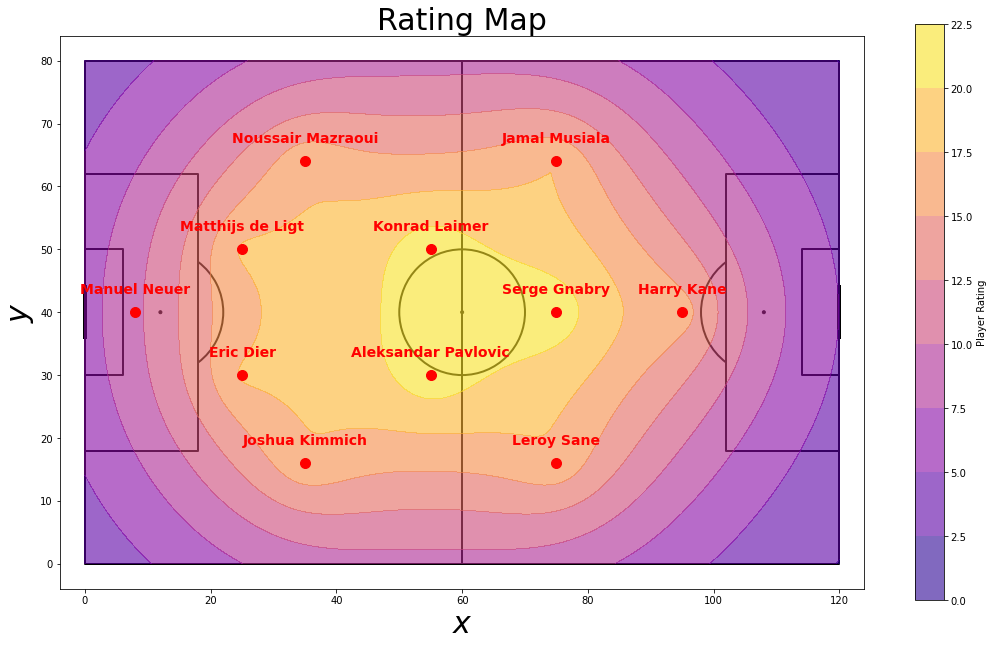

In [18]:
# Define grid dimensions
width = 121
height = 81

# Create a mesh grid
x = np.arange(0, width)
y = np.arange(0, height)
X, Y = np.meshgrid(x, y)

# Define player ratings, coordinates, and names
player_ratings = [(95, 40, 7.65,'Harry Kane'),
                 (75, 16, 7.58, 'Leroy Sane'),
                 (75, 64, 7.94, 'Jamal Musiala'),
                 (75, 40, 7.3, 'Serge Gnabry'),
                 (35, 16, 7.23, 'Joshua Kimmich'),
                 (35, 64, 6.78, 'Noussair Mazraoui'),
                 (55, 30, 6.95, 'Aleksandar Pavlovic'),
                 (55, 50, 6.88, 'Konrad Laimer'),
                 (25, 50, 6.95, 'Matthijs de Ligt'),
                 (25, 30, 6.74, 'Eric Dier'),
                 (8, 40, 0, 'Manuel Neuer')]

# Define decay function
def decay(distance, decay_factor=0.05):
    return np.exp(-decay_factor * distance)

# Initialize rating grid
ratings_grid = np.zeros((height, width))

# Calculate ratings for each player
for px, py, rating, _ in player_ratings:
    distance = np.sqrt((X - px) ** 2 + (Y - py) ** 2)
    ratings_grid += rating * decay(distance)

# Create the pitch
pitch = Pitch(pitch_color='white', axis=True, label=True, line_color='black', tick=True)
fig, ax = pitch.draw(figsize=(15, 9))

# Plot contour on the pitch
contour = ax.contourf(X, Y, ratings_grid, cmap='plasma', alpha=0.6)
plt.colorbar(contour, ax=ax, label='Player Rating')

# Scatter plot with annotations for each player
for px, py, _, player_name in player_ratings:
    plt.scatter(px, py, color='red', zorder=10, s=100)  # Add marker for player rating point
    ax.annotate(player_name, (px, py), xytext=(px, py + 3), color='red', fontsize=14, ha='center', fontweight='bold')
    
# Customize pitch
ax.set_xlabel('$x$', fontsize = 30)
ax.set_ylabel('$y$', fontsize = 30)
ax.invert_yaxis()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title('Rating Map', fontsize = 30)

plt.show()

In [19]:
np.size(player_ratings)

44

# THE CODE BELOW PLOTS HEAT MAPS OF PASSES RECEIVED. SOURCE: MEDIUM ARTICLE

In [20]:
###THIS BLOCK IS ALL REFERENCE

# # Read data
# df = pd.read_csv("WalkthroughLaLiga.csv")

# # Define the player names
# Real_Madrid = [
#     "Marcelo",
#     "Eder Militão",
#     "Íñigo Martínez",
#     "Daniel Carvajal",
#     "Casemiro",
#     "Toni Kroos",
#     "Luka Modric",
#     "Vinícius Júnior",
#     "Rodrygo",
#     "Karim Benzema"
# ]

# # Create pitch object with 120 x 80 dimensions
# pitch = Pitch(pitch_type='opta', pitch_color='#edece9', axis=True, label=True, line_color='#082630', tick=True)

# # Plot KDE heat maps for selected players
# for player_name in Real_Madrid:
#     # Filter dataframe to only include passes received by the selected player
#     player_df = df[df['receiver'] == player_name]
    
#     # Calculate KDE
#     kde = gaussian_kde(np.vstack([player_df.end_x, player_df.end_y]))
    
#     # Evaluate KDE probabilities at each x, y coordinate
#     x_grid, y_grid = np.mgrid[min(player_df.end_x):max(player_df.end_x):120j, min(player_df.end_y):max(player_df.end_y):80j]
#     positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
#     kde_prob = kde(positions).reshape(x_grid.shape)
#     kde_prob = kde_prob/np.max(kde_prob) #normalize
    
#     # Print KDE matrix
# #     print(f"KDE Matrix for {player_name}:")
# #     print(kde_prob)
# #     print("\n")    
    
#     # Draw pitch
#     fig, ax = pitch.draw(figsize=(10, 4))
    
#     # Plot KDE heat map
#     kde_plot = pitch.kdeplot(player_df.end_x, player_df.end_y, statistic='count', ax=ax, cmap='viridis',
#                              shade=True, shade_lowest=False, n_levels=400, linewidths=3, alpha=.5, zorder=.99)
    
#     # Add colorbar
#     sm = plt.cm.ScalarMappable(cmap='viridis')
#     sm.set_array([])  # Set dummy array to ensure the colorbar knows the range of values
#     colorbar = plt.colorbar(sm, ax=ax)
#     colorbar.set_label('Location Probability')

    
#     ax.set_xlabel('$x$', fontsize=15)
#     ax.set_ylabel('$y$', fontsize=15)
#     ax.xaxis.set_ticks_position('bottom')
#     ax.yaxis.set_ticks_position('left')
#     ax.set_title(f'{player_name} Heatmap', fontsize=15)
    
#     # Show the plot
#     plt.show()

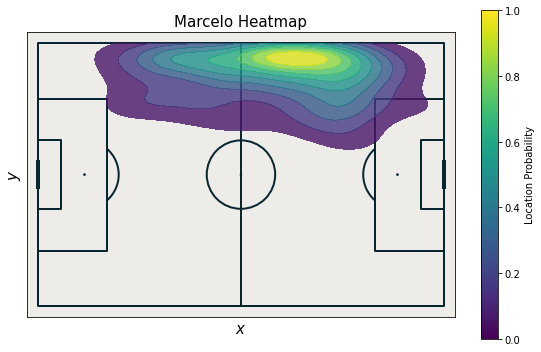

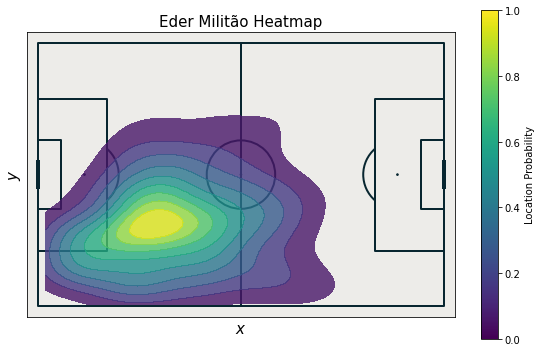

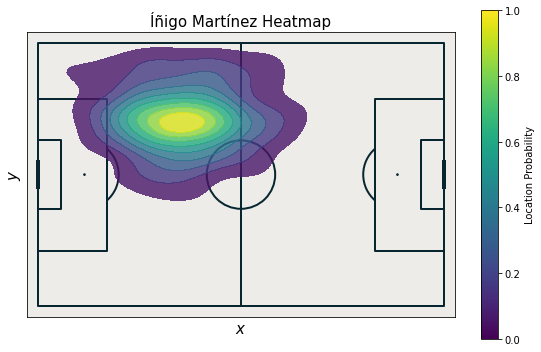

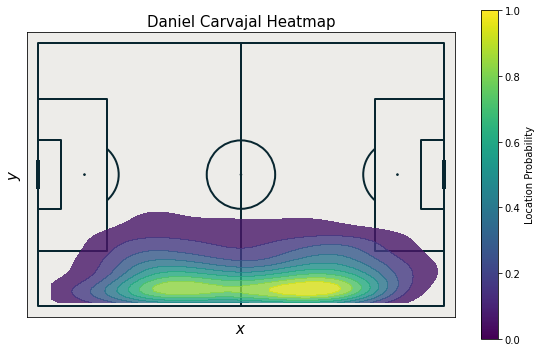

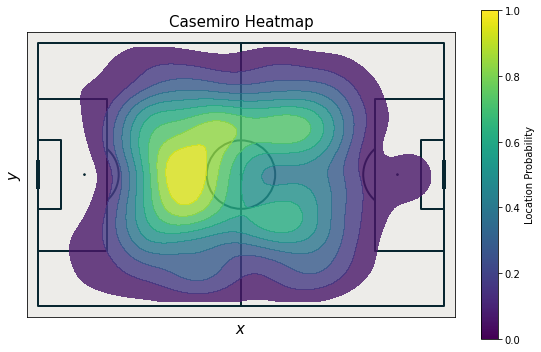

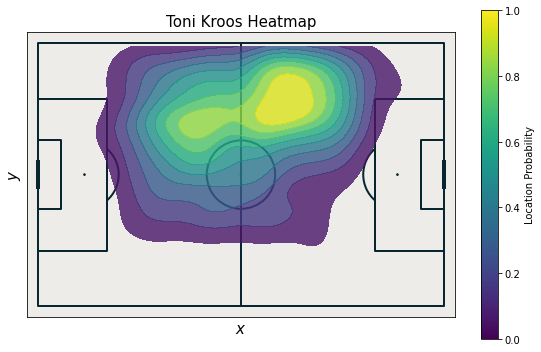

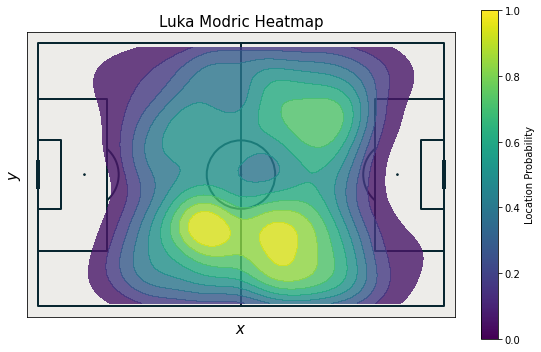

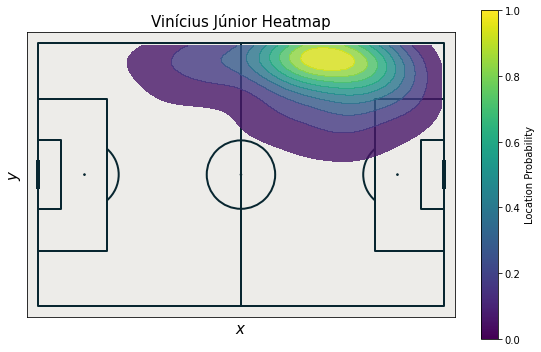

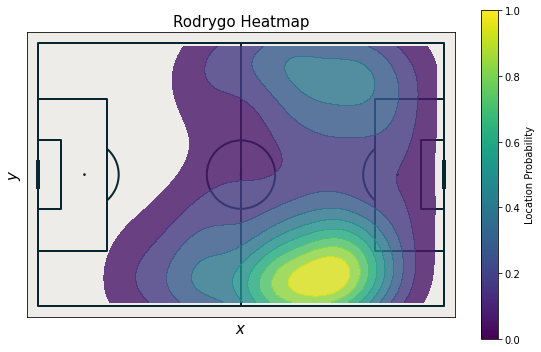

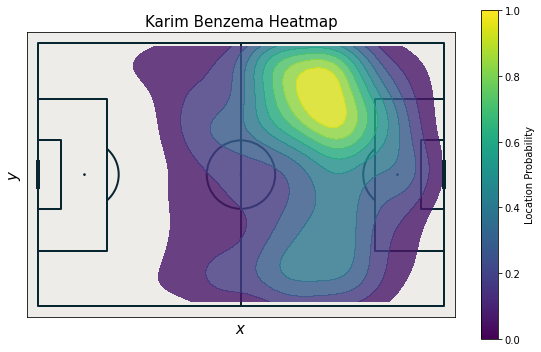

In [21]:
# Read data
data = pd.read_csv("WalkthroughLaLiga.csv")

# Create an empty dictionary to store probabilities for each player
player_probs = {}

# Define the player names
Real_Madrid = [
    "Marcelo",
    "Eder Militão",
    "Íñigo Martínez",
    "Daniel Carvajal",
    "Casemiro",
    "Toni Kroos",
    "Luka Modric",
    "Vinícius Júnior",
    "Rodrygo",
    "Karim Benzema"
]

# Create pitch object with 120 x 80 dimensions
pitch = Pitch(pitch_type='opta', pitch_color='#edece9', axis=True, label=False, line_color='#082630', tick=False)

# Plot KDE heat maps and contour plots for selected players
for player in Real_Madrid:
    # Filter dataframe to only include passes received by the selected player
    player_data = data[data['receiver'] == player]
    
    # Calculate KDE
    kde = gaussian_kde(np.vstack([player_data.end_x, player_data.end_y]))
    
    # Evaluate KDE probabilities at each x, y coordinate
    x_grid, y_grid = np.mgrid[min(player_data.end_x):max(player_data.end_x):120j, min(player_data.end_y):max(player_data.end_y):80j]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    prob = kde(positions).reshape(x_grid.shape)
    prob = prob / np.max(prob)  # normalize
    
    # Store probability matrix in a dictionary
    player_probs[player] = prob   
    
    # Plot KDE heat map
    fig, ax = pitch.draw(figsize=(8, 5))
    
    # Plot KDE heat map
#     kde_plot = pitch.kdeplot(player_data.end_x, player_data.end_y, ax=ax, cmap='viridis',
#                              shade=True, shade_lowest=False, n_levels=400, linewidths=3, alpha=.5, zorder=.99)
    
    # Overlay contour plot directly on the pitch
    ax.contourf(x_grid, y_grid, prob, cmap='viridis', alpha=.8, locator = ticker.MaxNLocator(prune = 'lower'))
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis')
    sm.set_array([])  # Set dummy array to ensure the colorbar knows the range of values
    colorbar = plt.colorbar(sm, ax=ax)
    colorbar.set_label('Location Probability')

    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title(f'{player} Heatmap', fontsize=15)
    
    plt.show()

In [6]:
np.shape(kde_prob)

(120, 80)

In [14]:
prob[119][79]

0.026974398094109942